# Analyzing CRC models

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import color_pal as pal
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_sampling_api
import seaborn as sns
from pymc3_models import crc_models
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data_dir = Path("..", "modeling_data", "depmap_CRC_data_subsample.csv")
data = dphelp.read_achilles_data(data_dir, low_memory=False)
data.shape

(34760, 30)

## Model 1

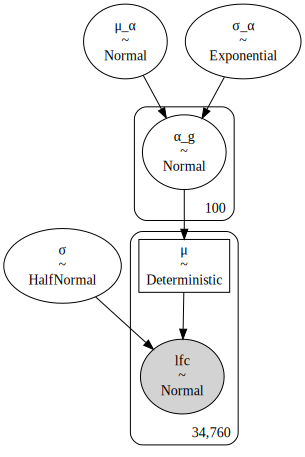

In [3]:
m1_cache_dir = pymc3_cache_dir / "CRC_test_model1"

gene_idx = dphelp.get_indices(data, "hugo_symbol")

crc_model1, gene_idx_shared, lfc_data_shared = crc_models.model_1(
    gene_idx=gene_idx, lfc_data=data.lfc.values
)
pm.model_to_graphviz(crc_model1)

In [4]:
crc_model1_res = pymc3_sampling_api.read_cached_vi(m1_cache_dir)

Loading cached trace and posterior sample...


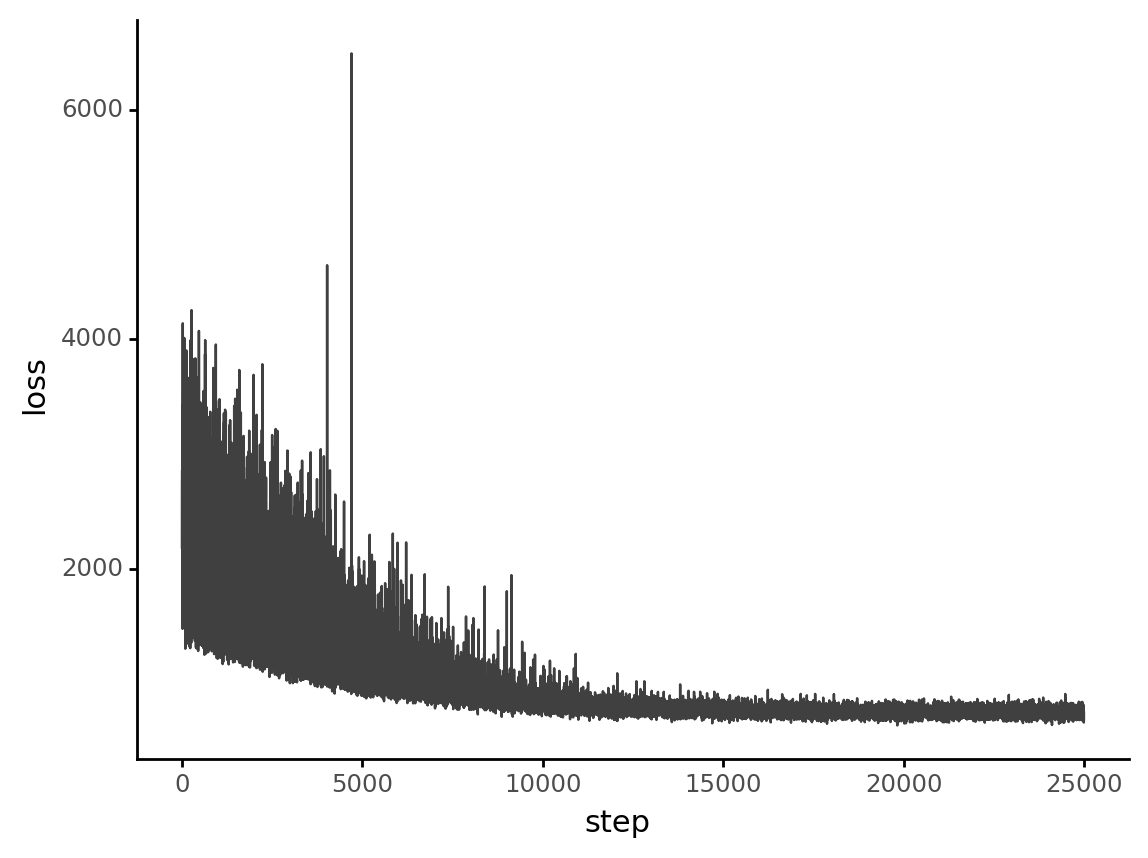

<ggplot: (8731821608241)>

In [5]:
d = pd.DataFrame({"loss": crc_model1_res["approximation"].hist}).assign(
    step=lambda d: np.arange(d.shape[0])
)

(
    gg.ggplot(d, gg.aes(x="step", y="loss"))
    + gg.geom_line(size=0.5, alpha=0.75, color="black")
)

In [6]:
crc_m1_az = az.from_pymc3(trace=crc_model1_res["trace"], model=crc_model1)
az.summary(crc_m1_az, var_names=["μ_α", "σ_α", "σ"], hdi_prob=0.89)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.128,0.036,-0.186,-0.072,0.001,0.001,996.0,996.0,995.0,1024.0,NaN
σ_α,0.319,0.025,0.282,0.360,0.001,0.001,1031.0,1031.0,1023.0,905.0,NaN
σ,0.510,0.008,0.495,0.522,0.000,0.000,1038.0,1038.0,1035.0,862.0,NaN


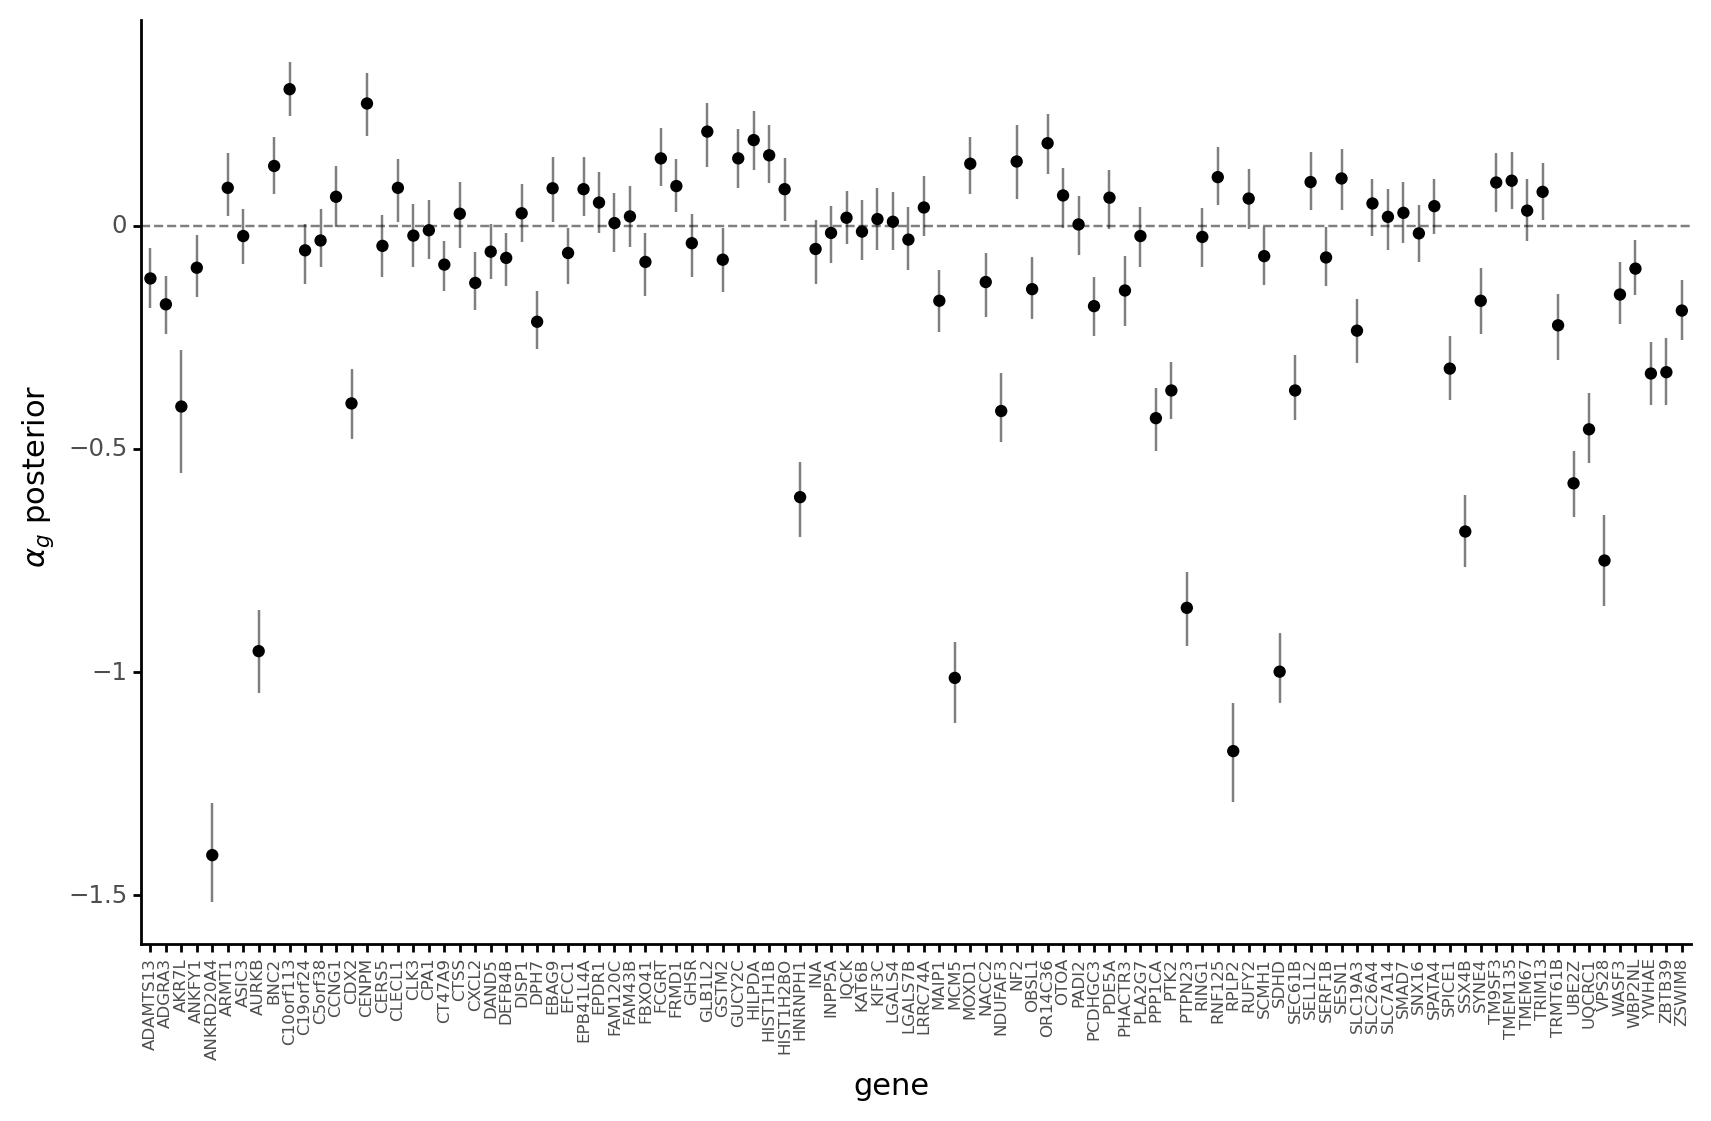

<ggplot: (8731783520446)>

In [7]:
gene_post = az.summary(crc_m1_az, var_names=["α_g"], hdi_prob=0.89, kind="stats")
gene_post["hugo_symbol"] = data.hugo_symbol.cat.categories.values
gene_post = gene_post.merge(
    data.groupby("hugo_symbol")["lfc"].agg(np.mean).reset_index(drop=False),
    on="hugo_symbol",
)

gene_ggplot_theme = {
    "axis_text_x": gg.element_text(angle=90, size=6),
    "figure_size": (10, 6),
}

(
    gg.ggplot(gene_post, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5)
    + gg.geom_point(gg.aes(y="mean"))
    + gg.theme(**gene_ggplot_theme)
    + gg.labs(x="gene", y=r"$\alpha_g$ posterior")
)

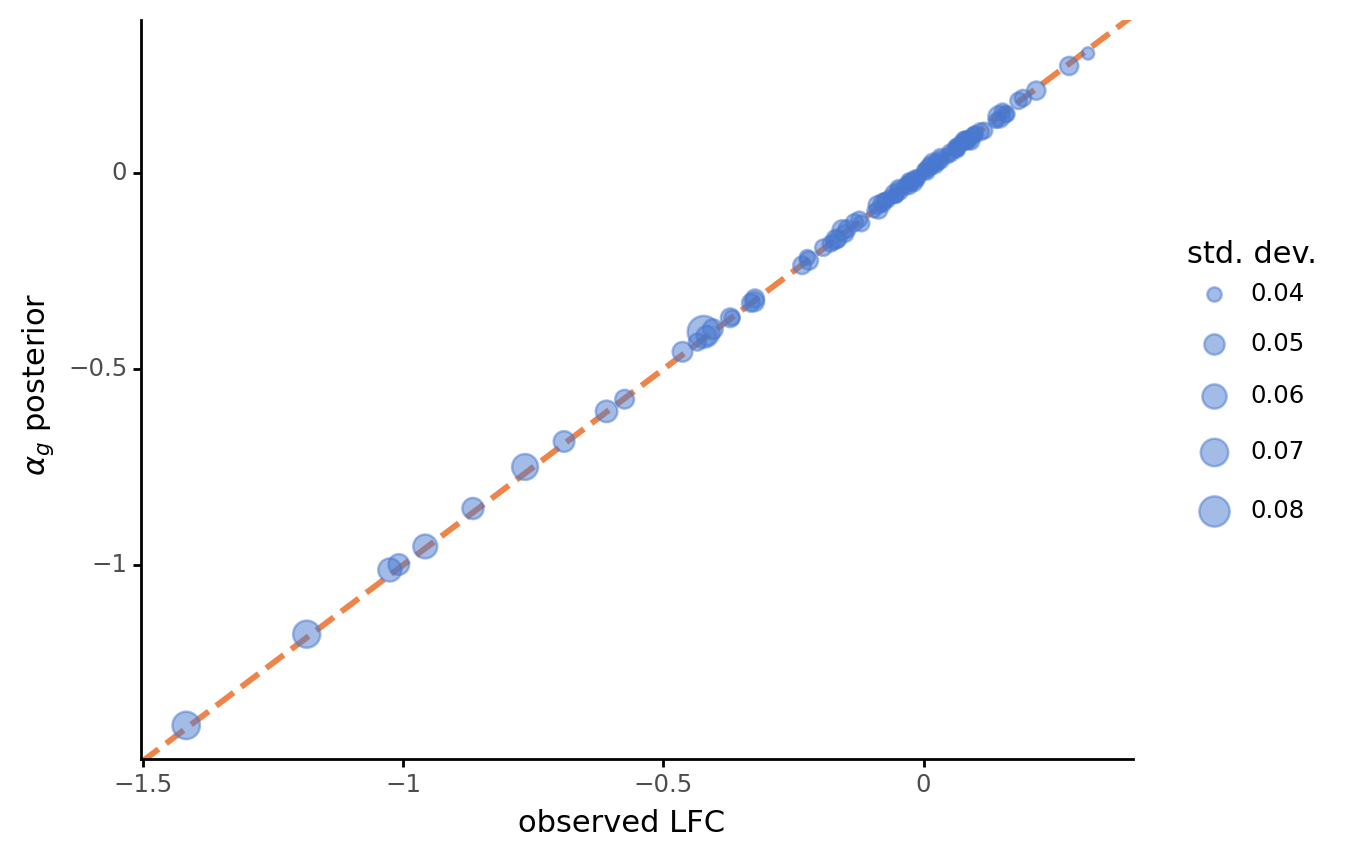

<ggplot: (8731783517546)>

In [8]:
(
    gg.ggplot(gene_post, gg.aes(x="lfc", y="mean"))
    + gg.geom_abline(
        slope=1, intercept=0, linetype="--", color=pal.sns_orange, size=1.2
    )
    + gg.geom_point(gg.aes(size="sd"), alpha=0.5, color=pal.sns_blue)
    + gg.labs(x="observed LFC", y=r"$\alpha_g$ posterior", size="std. dev.")
)

The posterior predictive check has the wrong dimensions; it is using the last minibatch for predicitions.
I need to follow the guidance of this [post](https://discourse.pymc.io/t/minibatch-advi-ppc-dimensions/5583) on the Discourse which followed the explanation in this GitHub [issue](https://github.com/pymc-devs/pymc3/issues/2190#issuecomment-311609342).
Should be a simple fix.

In [9]:
crc_model1_res["posterior_predictive"]["lfc"].shape[1] == data.shape[0]

True

In [10]:
def ppc_dataframe(ppc: np.ndarray, hdi_prob=0.89) -> pd.DataFrame:
    hdi = az.hdi(ppc, hdi_prob=hdi_prob)
    return pd.DataFrame(
        {
            "ppc_mean": ppc.mean(axis=0),
            "ppc_hdi_low": hdi[:, 0],
            "ppc_hdi_high": hdi[:, 1],
        }
    )


m1_ppc_df = ppc_dataframe(crc_model1_res["posterior_predictive"]["lfc"])
m1_ppc_df["real_lfc"] = data.lfc.values
m1_ppc_df["hugo_symbol"] = data.hugo_symbol.values

m1_ppc_df.head()

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,ppc_mean,ppc_hdi_low,ppc_hdi_high,real_lfc,hugo_symbol
0,-0.140320,-1.001702,0.618150,0.029491,ADAMTS13
1,-0.128909,-0.896227,0.687206,0.426017,ADAMTS13
2,-0.144695,-0.948575,0.670772,0.008626,ADAMTS13
3,-0.109424,-0.900942,0.655753,0.280821,ADAMTS13
4,-0.141217,-1.015847,0.581773,0.239815,ADAMTS13


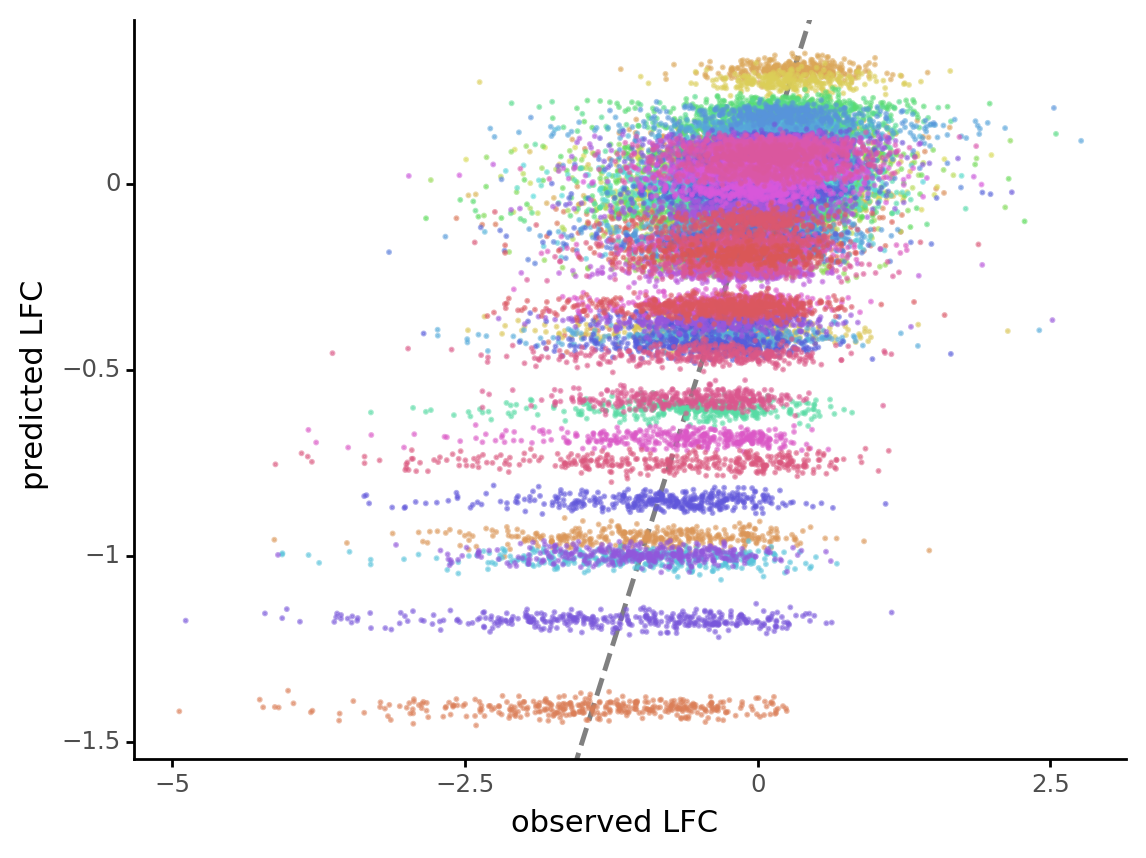

<ggplot: (8731821607376)>

In [11]:
(
    gg.ggplot(m1_ppc_df, gg.aes(x="real_lfc", y="ppc_mean"))
    + gg.geom_abline(slope=1, intercept=0, color="gray", linetype="--", size=1)
    + gg.scale_color_discrete()
    + gg.geom_point(gg.aes(color="hugo_symbol"), size=0.2, alpha=0.5)
    + gg.theme(legend_position="none")
    + gg.labs(x="observed LFC", y="predicted LFC")
)

## Predict on new data

In [12]:
pred_data = data[["hugo_symbol"]].drop_duplicates().reset_index(drop=True)

pred_gene_idx = dphelp.get_indices(pred_data, "hugo_symbol")
gene_idx_shared.set_value(pred_gene_idx)

In [13]:
with crc_model1:
    pred_ppc = pm.sample_posterior_predictive(
        trace=crc_model1_res["trace"], samples=100
    )

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


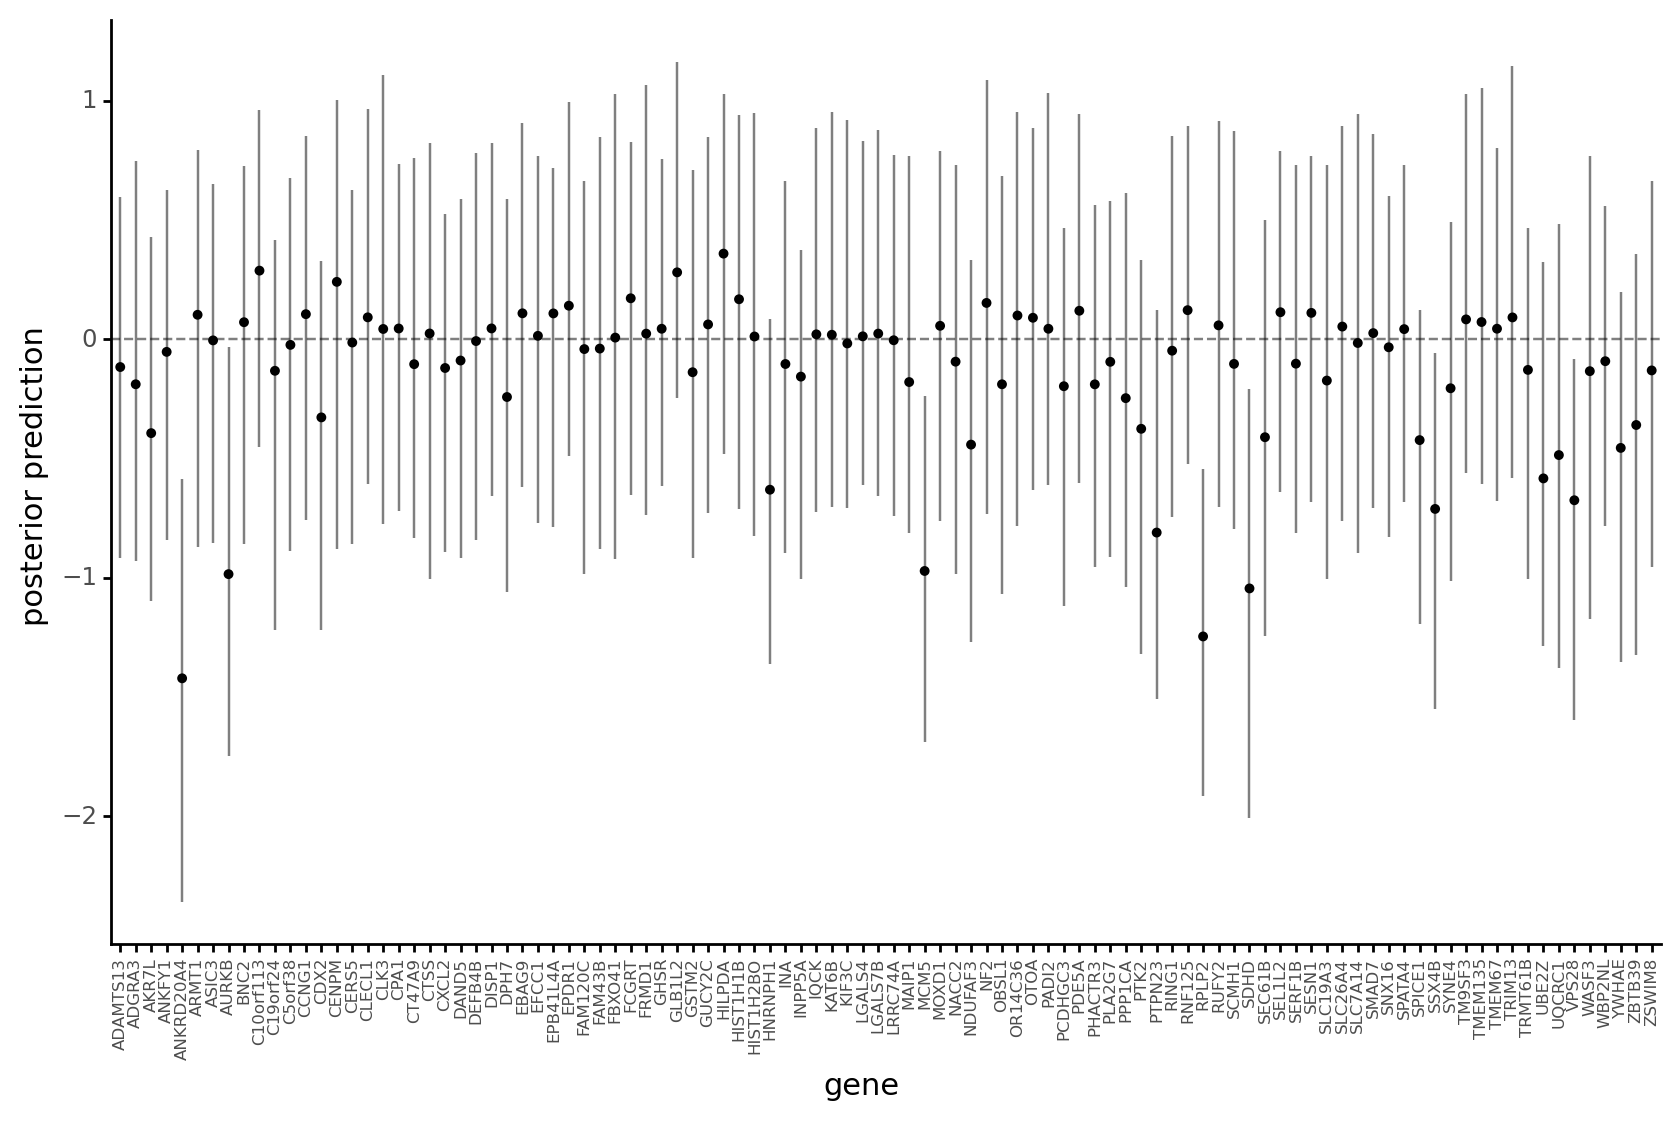

<ggplot: (8731783517537)>

In [14]:
new_ppc = ppc_dataframe(pred_ppc["lfc"])
new_ppc["hugo_symbol"] = pred_data.hugo_symbol.values
(
    gg.ggplot(new_ppc, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(
        gg.aes(ymin="ppc_hdi_low", ymax="ppc_hdi_high"), size=0.5, alpha=0.5
    )
    + gg.geom_point(gg.aes(y="ppc_mean"), size=1)
    + gg.theme(**gene_ggplot_theme)
    + gg.labs(x="gene", y="posterior prediction")
)

### To-Do:

1. Address the change above to fix an issue with PPC sampling. <span style="color:green">✔︎</span>
2. Make sure I can replace the shared data with new data for predictions on unseen data. <span style="color:green">✔︎</span>
3. Run and analyze more simple models.
4. Create a Snakemake workflow to run all in parallel and then run the analysis.

---

In [15]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.97 minutes


In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-19

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-86.o2.rc.hms.harvard.edu

Git branch: crc

arviz     : 0.11.1
numpy     : 1.20.1
re        : 2.2.1
pandas    : 1.2.2
plotnine  : 0.7.1
matplotlib: 3.3.4
pymc3     : 3.11.1
theano    : 1.0.5
seaborn   : 0.11.1

